<a href="https://colab.research.google.com/github/elpeme/w281_final_project/blob/main/CIFAR_HOG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import time
import cv2
from sklearn.model_selection import train_test_split
from joblib import parallel_backend
import tensorflow as tf

import matplotlib.pyplot as plt
# import seaborn as sns
import textwrap

from keras.preprocessing import image
# %matplotlib inline

from skimage.feature import hog
from sklearn.metrics import accuracy_score
import pickle
import sklearn.svm as svm

import pandas as pd
import numpy as np
from PIL import Image
import PIL
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import image as mpimg

from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier
import multiprocessing


In [2]:
# To use all available CPUs with Scikit learn
n_cpus = multiprocessing.cpu_count()

In [5]:
# Enabling TPU
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.TPUStrategy(tpu)
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)

Tensorflow version 2.12.0
Running on TPU  ['10.99.76.242:8470']


In [3]:
# Load CIFAR dataset from Keras
cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()


from google.colab import drive
drive.mount('/content/drive')

# Path used to save the models 
cifar100_path = '/content/drive/MyDrive/W281 Computer Vision/w281_final_project/cifar100/'

169001437/169001437 [==============================] - 4s 0us/step
Mounted at /content/drive


In [ ]:
# This is to use Huggingface dataset
# from datasets import load_dataset

# dataset = load_dataset("cifar100")
# dataset


In [4]:
# Categories labels 
fine_label = [ 'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm',
]

mapping = {
'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor'],
}
coarse_label = list(mapping.keys())

fine_id_coarse_id =  {0: 4,  1: 1,  2: 14,  3: 8,  4: 0,  5: 6,  6: 7,  7: 7,  8: 18,  9: 3,  
                      10: 3,  11: 14,  12: 9,  13: 18,  14: 7,  15: 11,  16: 3,  17: 9,  18: 7,  19: 11,  
                      20: 6,  21: 11,  22: 5,  23: 10,  24: 7,  25: 6,  26: 13,  27: 15,  28: 3,  29: 15,  
                      30: 0,  31: 11,  32: 1,  33: 10,  34: 12,  35: 14,  36: 16,  37: 9,  38: 11,  39: 5,  
                      40: 5,  41: 19,  42: 8,  43: 8,  44: 15,  45: 13,  46: 14,  47: 17,  48: 18,  49: 10,  
                      50: 16,  51: 4,  52: 17,  53: 4,  54: 2,  55: 0,  56: 17,  57: 4,  58: 18,  59: 17,  
                      60: 10,  61: 3,  62: 2,  63: 12,  64: 12,  65: 16,  66: 12,  67: 1,  68: 9,  69: 19,  
                      70: 2,  71: 10,  72: 0,  73: 1,  74: 16,  75: 12,  76: 9,  77: 13,  78: 15,  79: 13,  
                      80: 16,  81: 19,  82: 2,  83: 4,  84: 6,  85: 19,  86: 5,  87: 5,  88: 8,  89: 19,  
                      90: 18,  91: 1,  92: 2,  93: 15,  94: 6,  95: 0,  96: 17,  97: 8,  98: 14,  99: 13}



wrapper = textwrap.TextWrapper(width=15, break_long_words=True)

def fine_to_named_coarse_label(fine_label_id):
  label = wrapper.wrap(coarse_label[fine_id_coarse_id[fine_label_id]])
  return '\n'.join(label)

def get_named_coarse_label(coarse_label_id):
  label = wrapper.wrap(coarse_label[coarse_label_id])
  return '\n'.join(label)

In [5]:
# Data wrangling --> Creating the coarse train arrays since we will train the model based on the 20 coarse categories 
Y_train = np.asarray([fine_id_coarse_id[x[0]] for x in Y_train])

Y_test= np.asarray([fine_id_coarse_id[x[0]] for x in Y_test])


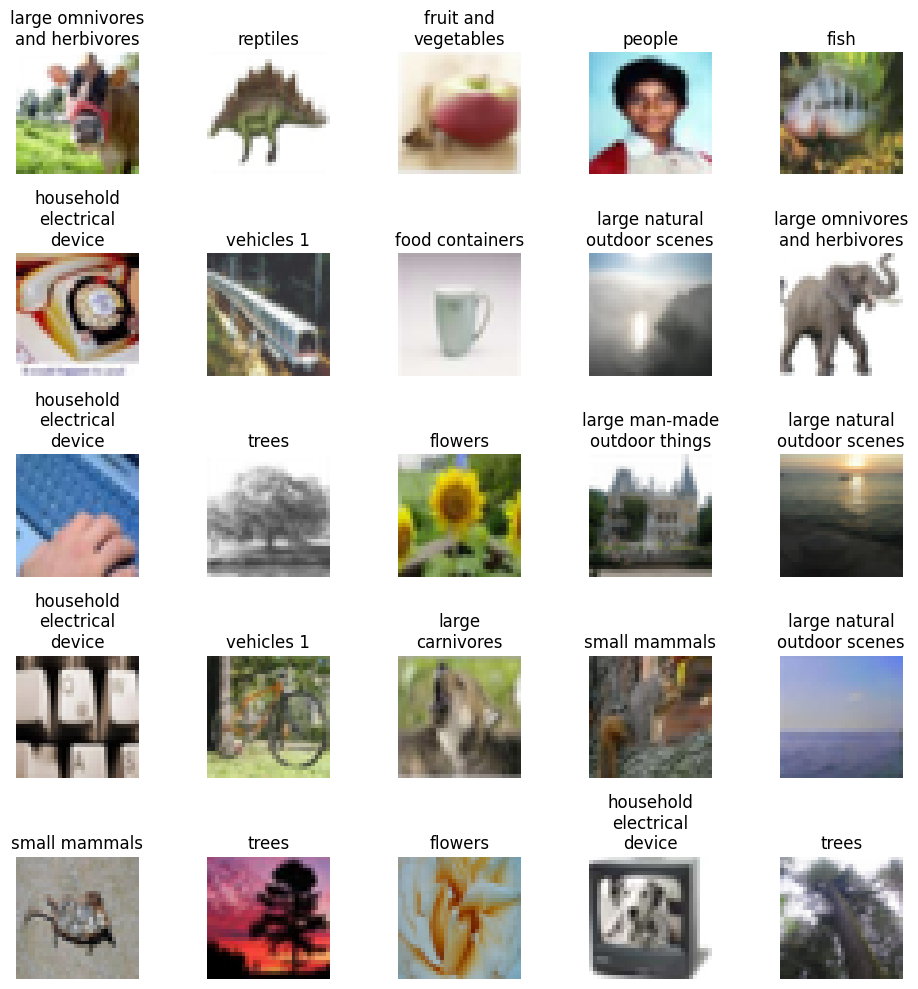

In [68]:
# EDA to show random sample images by coarse category
plt.figure(figsize = (10,10))
for i in range(25):
  plt.subplot(5,5,1+i)
  plt.axis('off')
  plt.title(get_named_coarse_label(Y_train[i]))
  plt.tight_layout()
  plt.imshow(X_train[i])

# HOG display for the first 5 random images in the dataset

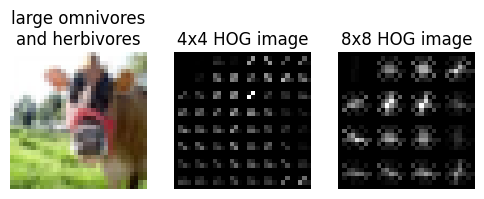

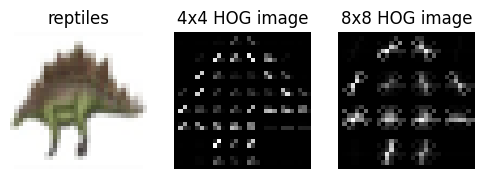

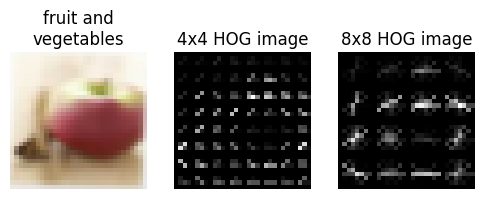

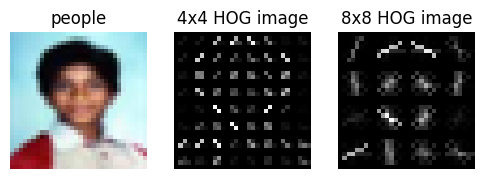

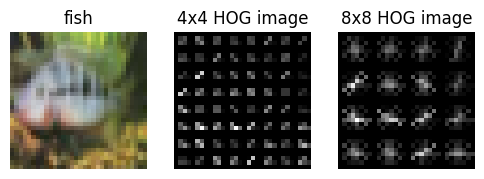

In [69]:
# HOG display for the first 5 random images in the dataset using two different kernel sizes

for i in range(5):
  image = X_train[i]
  fd_4x4, hog_img_4x4 = hog(image, orientations=9, pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2), visualize=True, channel_axis = -1)
  fd_8x8, hog_img_8x8 = hog(image, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, channel_axis = -1)

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 6), sharex=True, sharey=True)

  ax1.axis('off')
  ax1.imshow(image, cmap=plt.cm.gray)
  ax1.set_title(get_named_coarse_label(Y_train[i]))

      
  ax2.axis('off')
  ax2.imshow(hog_img_4x4, cmap=plt.cm.gray)
  ax2.set_title(f'4x4 HOG image')

  ax3.axis('off')
  ax3.imshow(hog_img_8x8, cmap=plt.cm.gray)
  ax3.set_title(f'8x8 HOG image')

  plt.show()


## Building SVM models

In [75]:
# Build  model with HOG using 4x4 cell 

x_train_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(4, 4),
                      cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_train])  

x_test_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_test])  

with parallel_backend('threading', n_jobs = n_cpus):
  hog_model = svm.SVC(kernel = 'rbf')
  hog_model.fit(x_train_hog_np , Y_train.ravel())
  prdct = hog_model.predict(x_test_hog_np)



# Save files
filename = cifar100_path + 'hog_model_4by4.sav'
pickle.dump(hog_model, open(filename, 'wb'))

filename = cifar100_path + 'hog_model_4by4_predict.sav'
pickle.dump(prdct, open(filename, 'wb'))


In [6]:
# HOG using 8x8 cell
x_train_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_train])  

x_test_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_test])  


In [71]:
# Train SVM model with HOG using 8x8 cell 

with parallel_backend('threading', n_jobs = n_cpus):
  hog_model = svm.SVC(kernel = 'rbf')
  hog_model.fit(x_train_hog_np , Y_train.ravel())

  prdct = hog_model.predict(x_test_hog_np)


# Save model and accuracy cresults
filename = cifar100_path + 'hog_model_8by8.sav'
pickle.dump(hog_model, open(filename, 'wb'))


filename = cifar100_path + 'hog_model_8by8_predict.sav'
pickle.dump(prdct, open(filename, 'wb'))


In [74]:
# Evaluate the two SVM HOG models 

predictions_4x4 = pickle.load( open( cifar100_path + 'hog_model_4by4_predict.sav', "rb" ))
print("Accuracy with 4x4 HOG kernel: ", accuracy_score(Y_test , predictions_4x4))

predictions_8x8 = pickle.load( open( cifar100_path + 'hog_model_8by8_predict.sav', "rb" ))
print("Accuracy with 8x8 HOG kernel: ", accuracy_score(Y_test , predictions_8x8))


Accuracy with 4x4 HOG kernel:  0.3772
Accuracy with 8x8 HOG kernel:  0.3979


# Logistic regression

In [7]:
# Logistic regression model 
with parallel_backend('threading', n_jobs=n_cpus):
  logreg= LogisticRegression(max_iter=5000)

  logreg.fit(x_train_hog_np , Y_train.ravel())

  y_pred_logreg = logreg.predict(x_test_hog_np)

  accuracy_logreg = accuracy_score(Y_test , y_pred_logreg)


# Save model and accuracy cresults
filename = cifar100_path + 'log_regression.sav'
pickle.dump(logreg, open(filename, 'wb'))


filename = cifar100_path + 'log_regression_predictions.sav'
pickle.dump(y_pred_logreg, open(filename, 'wb'))


In [8]:
print("Accuracy with Logistic regression: ", accuracy_logreg)

Accuracy with Logistic regression:  0.3019


# Random Forest Classifier

In [9]:
with parallel_backend('threading', n_jobs=n_cpus):
  rf = RandomForestClassifier()

  rf.fit(x_train_hog_np, Y_train.ravel())

  y_pred_rf = rf.predict(x_test_hog_np)
  accuracy_random_forest = accuracy_score(Y_test , y_pred_rf)

# Save model and accuracy cresults
filename = cifar100_path + 'random_forest_model.sav'
pickle.dump(rf, open(filename, 'wb'))


filename = cifar100_path + 'random_forest_predictions.sav'
pickle.dump(y_pred_rf, open(filename, 'wb'))


In [10]:
print("Accuracy with Random Forest: ", accuracy_random_forest)

Accuracy with Random Forest:  0.2905


# Evaluating with only 5 classes


In [11]:
# Testing with only 5 classes

cifar100 = tf.keras.datasets.cifar100
(X_train,Y_train) , (X_test,Y_test) = cifar100.load_data()

 
five_classes = [11, 5, 9, 6, 18]
mask_train = np.isin(Y_train, five_classes)
mask_test = np.isin(Y_test, five_classes)
X_train_5 = []
X_test_5 = []

for i in range(mask_train.shape[0]):
  if mask_train[i]:
    X_train_5.append(X_train[i])

for i in range(mask_test.shape[0]):
  if mask_test[i]:
    X_test_5.append(X_test[i])

X_train = np.asarray(X_train_5)
X_test = np.asarray(X_test_5)
Y_train = Y_train[mask_train]
Y_test = Y_test[mask_test]


# # Data wrangling --> Creating the coarse train arrays since we will train the model based on the 20 coarse categories 
Y_train = np.asarray([fine_id_coarse_id[x] for x in Y_train])

Y_test= np.asarray([fine_id_coarse_id[x] for x in Y_test])


In [12]:
# Build HOG trains and test arrays
x_train_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_train])  

x_test_hog_np = np.array([hog(image, orientations=9, pixels_per_cell=(8, 8),
                      cells_per_block=(2, 2), visualize=False, channel_axis = -1) for image in X_test])  


In [13]:
with parallel_backend('threading', n_jobs = n_cpus):
  # SVM model
  hog_model = svm.SVC(kernel = 'rbf')
  hog_model.fit(x_train_hog_np , Y_train.ravel())
  svm_predict = hog_model.predict(x_test_hog_np)
  accuracy_svm = accuracy_score(Y_test , svm_predict)

  # Logistic regression model 
  logreg= LogisticRegression(max_iter=5000)
  logreg.fit(x_train_hog_np , Y_train.ravel())
  y_pred_logreg = logreg.predict(x_test_hog_np)
  accuracy_logreg = accuracy_score(Y_test , y_pred_logreg)

  # Random forest model
  rf = RandomForestClassifier()
  rf.fit(x_train_hog_np, Y_train.ravel())
  y_pred_rf = rf.predict(x_test_hog_np)
  accuracy_random_forest = accuracy_score(Y_test , y_pred_rf)


In [15]:
print("Accuracy with only 5 classes")
print("SVM model: ", accuracy_svm)
print("Linear regression model: ", accuracy_logreg)
print("Random forest model: ", accuracy_random_forest)

Accuracy with only 5 classes
SVM model:  0.792
Linear regression model:  0.738
Random forest model:  0.734
